# GradCAM Analysis for EfficientNet-B0 Model in Autism Detection

This notebook implements Gradient-weighted Class Activation Mapping (GradCAM) visualization specifically for the EfficientNet-B0 model to understand why it performed well on autism detection and identify its success patterns.

## Overview
GradCAM analysis helps us understand EfficientNet-B0's success patterns by:
- **Visualizing Attention**: See where the model focuses during predictions
- **Identifying Architectural Strengths**: Understand how compound scaling affects attention
- **Detecting Effective Learning**: Find evidence of proper feature extraction
- **Analyzing Spatial Patterns**: Examine how the model processes facial features
- **Comparing with Other Models**: Understand differences from other architectures


# 1. Import Required Libraries

Import all necessary libraries for GradCAM analysis, EfficientNet-B0 model loading, and visualization.

In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-vcq6qk7_
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-vcq6qk7_
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [2]:
!pip install --upgrade pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.

In [3]:
# Core libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

# GradCAM libraries
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Sklearn for metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Setup Environment Configuration

Configure environment settings and check library versions, GPU availability, and verify GradCAM import for EfficientNet-B0 model analysis.

In [4]:
# Check versions of key libraries
print("Library Versions:")
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

# Check PyTorch device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Verify GradCAM import
try:
    from pytorch_grad_cam import GradCAM
    print("✓ GradCAM successfully imported")
except ImportError as e:
    print(f"✗ GradCAM import failed: {e}")

# Verify torchvision import for EfficientNet-B0 model
try:
    import torchvision.models as models
    print("✓ torchvision successfully imported")
    
    # Check if EfficientNet-B0 is available in torchvision
    available_models = [name for name in dir(models) if 'efficientnet' in name.lower()]
    print(f"✓ Available EfficientNet models in torchvision: {len(available_models)}")
    for model in sorted(available_models):
        print(f"  - {model}")
        
except ImportError as e:
    print(f"✗ torchvision import failed: {e}")

# Check if model files exist
model_path_options = [
    "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results",
    "/Applications/Projects/ASD_Research/models",
    "/Applications/Projects/ASD_Research"
]

effnet_b0_model_found = False
for model_path in model_path_options:
    if os.path.exists(model_path):
        models_available = [f for f in os.listdir(model_path) if f.endswith('.pth')]
        effnet_b0_models = [m for m in models_available if 'effnet' in m.lower() and 'b0' in m.lower()]
        
        if effnet_b0_models:
            print(f"\n✓ EfficientNet-B0 model directory found: {model_path}")
            print(f"EfficientNet-B0 models found: {len(effnet_b0_models)}")
            for model in sorted(effnet_b0_models):
                print(f"  - {model}")
            effnet_b0_model_found = True
            break

if not effnet_b0_model_found:
    print(f"\n⚠️  EfficientNet-B0 model files not found in any of the checked paths:")
    for path in model_path_options:
        print(f"  - {path}")
    print("Please ensure EfficientNet-B0 model files are available for analysis.")

Library Versions:
PyTorch: 2.6.0+cu124
Torchvision: 0.21.0+cu124
NumPy: 1.26.4
Pandas: 2.2.3
Matplotlib: 3.7.2

Device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.4
✓ GradCAM successfully imported
✓ torchvision successfully imported
✓ Available EfficientNet models in torchvision: 24
  - EfficientNet
  - EfficientNet_B0_Weights
  - EfficientNet_B1_Weights
  - EfficientNet_B2_Weights
  - EfficientNet_B3_Weights
  - EfficientNet_B4_Weights
  - EfficientNet_B5_Weights
  - EfficientNet_B6_Weights
  - EfficientNet_B7_Weights
  - EfficientNet_V2_L_Weights
  - EfficientNet_V2_M_Weights
  - EfficientNet_V2_S_Weights
  - efficientnet
  - efficientnet_b0
  - efficientnet_b1
  - efficientnet_b2
  - efficientnet_b3
  - efficientnet_b4
  - efficientnet_b5
  - efficientnet_b6
  - efficientnet_b7
  - efficientnet_v2_l
  - efficientnet_v2_m
  - efficientnet_v2_s

✓ EfficientNet-B0 model directory found: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results
Efficien

# 3. Environment Configuration

Configure matplotlib, pandas, global variables, and set random seeds for reproducibility. Define paths for EfficientNet-B0 model files and output directories.

In [5]:
# Configure matplotlib for inline plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

# Configure seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Configure PyTorch for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define global variables for EfficientNet-B0 analysis
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model path options (check multiple possible locations)
MODEL_PATH_OPTIONS = [
    "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results",
    "/Applications/Projects/ASD_Research/models",
    "/Applications/Projects/ASD_Research"
]

# Find the actual model path
MODEL_PATH = None
for path in MODEL_PATH_OPTIONS:
    if os.path.exists(path):
        files = [f for f in os.listdir(path) if f.endswith('.pth')]
        if any('effnet' in f.lower() and 'b0' in f.lower() for f in files):
            MODEL_PATH = path
            break

if MODEL_PATH is None:
    MODEL_PATH = "/Applications/Projects/ASD_Research/models"  # Default fallback

# Data path options
DATA_PATH_OPTIONS = [
    "/kaggle/input/autism-image-data/AutismDataset",
    "/Applications/Projects/ASD_Research/AutismDataset",
    "/Applications/Projects/ASD_Research/ASD Data"
]

# Find the actual data path
DATA_PATH = None
for path in DATA_PATH_OPTIONS:
    if os.path.exists(path):
        DATA_PATH = path
        break

if DATA_PATH is None:
    DATA_PATH = "/Applications/Projects/ASD_Research/AutismDataset"  # Default fallback

OUTPUT_PATH = "/kaggle/working/"

# Target EfficientNet-B0 models for analysis
EFFNET_B0_MODELS = [
    'effnet-b0'
]

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("Environment configured successfully for EfficientNet-B0 analysis!")
print(f"Device: {DEVICE}")
print(f"Model path: {MODEL_PATH}")
print(f"Data path: {DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Target EfficientNet-B0 models: {EFFNET_B0_MODELS}")

# Additional EfficientNet-B0-specific configurations
print(f"\n=== EfficientNet-B0-Specific Configuration ===")
print("EfficientNet-B0 uses compound scaling which may affect GradCAM:")
print("- Different scaling factors for depth, width, and resolution")
print("- MBConv blocks with squeeze-and-excitation")
print("- May require special attention to layer selection")
print("- Potential issues with feature map resolution")

Environment configured successfully for EfficientNet-B0 analysis!
Device: cuda
Model path: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results
Data path: /kaggle/input/autism-image-data/AutismDataset
Output path: /kaggle/working/
Target EfficientNet-B0 models: ['effnet-b0']

=== EfficientNet-B0-Specific Configuration ===
EfficientNet-B0 uses compound scaling which may affect GradCAM:
- Different scaling factors for depth, width, and resolution
- MBConv blocks with squeeze-and-excitation
- May require special attention to layer selection
- Potential issues with feature map resolution


# 4. EfficientNet-B0 Model Architecture Definition

Define the EfficientNet-B0 model architecture class matching the original training implementation, including proper layer structure and target layer identification for GradCAM.

In [6]:
# EfficientNet-B0 Model Architecture - Based on torchvision implementation
class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(EfficientNetB0Model, self).__init__()
        self.num_classes = num_classes
        
        # Use torchvision's EfficientNet-B0
        self.model = models.efficientnet_b0(pretrained=pretrained)
        
        # Modify classifier for binary classification (no dropout used)
        num_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.model(x)
    
    def get_features(self, x):
        """Extract features before final classification"""
        return self.model.features(x)

def create_efficientnet_b0_model(num_classes=2, pretrained=True):
    """
    Create EfficientNet-B0 model for binary classification
    No dropout used - simple Linear layer classifier
    """
    print(f"🏗️  Creating EfficientNet-B0 model...")
    print(f"📊 Classes: {num_classes}")
    print(f"🚫 No dropout used - simple Linear classifier")
    
    try:
        model = EfficientNetB0Model(
            num_classes=num_classes,
            pretrained=pretrained
        )
        
        print(f"✅ Successfully created EfficientNet-B0 model")
        
        return model
        
    except Exception as e:
        print(f"❌ Failed to create EfficientNet-B0 model: {e}")
        raise e

def get_efficientnet_b0_target_layer(model):
    """
    Get the target layer for GradCAM - for EfficientNet-B0
    """
    print(f"🎯 Finding target layer for EfficientNet-B0...")
    
    target_layer = None
    
    try:
        # For EfficientNet-B0, find the last convolutional layer in features
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                target_layer = module
                last_conv_name = name
        
        if target_layer is not None:
            print(f"✅ Found target layer: {last_conv_name}")
            print(f"🔍 Layer type: {type(target_layer).__name__}")
            if hasattr(target_layer, 'out_channels'):
                print(f"📊 Output channels: {target_layer.out_channels}")
        else:
            print("❌ No suitable target layer found")
    
    except Exception as e:
        print(f"❌ Error finding target layer: {e}")
        target_layer = None
    
    return target_layer

def debug_efficientnet_b0_architecture(model):
    """
    Debug and analyze EfficientNet-B0 architecture
    """
    print(f"\n🔍 Debugging EfficientNet-B0 Architecture")
    print("=" * 50)
    
    # Get model structure
    print("\n📊 Model Structure:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"� Total parameters: {total_params:,}")
    print(f"🔧 Trainable parameters: {trainable_params:,}")
    
    # Find potential target layers
    print(f"\n🎯 Potential GradCAM target layers:")
    conv_layers = []
    bn_layers = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append((name, module))
        elif isinstance(module, nn.BatchNorm2d):
            bn_layers.append((name, module))
    
    print(f"� Found {len(conv_layers)} Conv2d layers")
    print(f"� Found {len(bn_layers)} BatchNorm2d layers")
    
    # Show last few convolutional layers (potential targets)
    print(f"\n🎯 Last 5 convolutional layers (best GradCAM targets):")
    for name, layer in conv_layers[-5:]:
        print(f"   {name}: {layer.out_channels} channels")
    
    return conv_layers, bn_layers

def load_efficientnet_b0_model(model_path, device):
    """Load EfficientNet-B0 model from checkpoint"""
    
    print(f"🔧 Loading EfficientNet-B0 model: {model_path}")
    
    try:
        # First, create a raw torchvision EfficientNet-B0 to match the saved checkpoint structure
        print(" Creating base torchvision EfficientNet-B0 model...")
        base_model = models.efficientnet_b0(pretrained=False)
        
        # Modify classifier for binary classification (no dropout used)
        num_features = base_model.classifier[1].in_features
        base_model.classifier[1] = nn.Linear(num_features, 2)
        
        # Now wrap it in our custom model class
        model = EfficientNetB0Model(num_classes=2, pretrained=False)
        model.model = base_model  # Replace the inner model
        
        # Load checkpoint
        print(" Loading checkpoint...")
        checkpoint = None
        
        # Try different loading strategies
        loading_strategies = [
            lambda: torch.load(model_path, map_location=device),
            lambda: torch.load(model_path, map_location='cpu'),
            lambda: torch.load(model_path, map_location='cuda:0' if torch.cuda.is_available() else 'cpu')
        ]
        
        for i, strategy in enumerate(loading_strategies):
            try:
                checkpoint = strategy()
                print(f"✓ Checkpoint loaded successfully (strategy {i+1})")
                break
            except Exception as e:
                print(f"⚠️  Loading strategy {i+1} failed: {e}")
                continue
        
        if checkpoint is None:
            raise RuntimeError("All loading strategies failed")
        
        # Handle different checkpoint formats
        state_dict = None
        if isinstance(checkpoint, dict):
            # Try different keys
            keys_to_try = ['state_dict', 'model', 'model_state_dict', 'net', 'network']
            for key in keys_to_try:
                if key in checkpoint:
                    state_dict = checkpoint[key]
                    print(f"✓ Loaded from '{key}' key")
                    break
            
            if state_dict is None:
                state_dict = checkpoint
                print("✓ Using checkpoint as state dict")
                
            print(f"📋 Checkpoint keys: {list(checkpoint.keys())}")
            if 'epoch' in checkpoint:
                print(f"🕐 Epoch: {checkpoint['epoch']}")
            if 'best_acc' in checkpoint:
                print(f"🎯 Best accuracy: {checkpoint['best_acc']}")
                
        else:
            state_dict = checkpoint
            print("✓ Using checkpoint directly")
        
        try:
            # Load the state dict into the base model first
            print(" Loading state dict into base model...")
            missing_keys, unexpected_keys = base_model.load_state_dict(state_dict, strict=False)
            
            if missing_keys:
                print(f"⚠️  Missing keys: {len(missing_keys)} keys")
                if len(missing_keys) <= 5:
                    for key in missing_keys:
                        print(f"   - {key}")
                else:
                    for key in missing_keys[:5]:
                        print(f"   - {key}")
                    print(f"   ... and {len(missing_keys) - 5} more")
                    
            if unexpected_keys:
                print(f"⚠️  Unexpected keys (ignored): {len(unexpected_keys)} keys")
                if len(unexpected_keys) <= 5:
                    for key in unexpected_keys:
                        print(f"   - {key}")
                else:
                    for key in unexpected_keys[:5]:
                        print(f"   - {key}")
                    print(f"   ... and {len(unexpected_keys) - 5} more")
            
            print("✅ Model state dict loaded successfully")
            
        except RuntimeError as e:
            print(f"❌ Model loading failed: {e}")
            return None, None
            
        print(f"✅ Successfully loaded EfficientNet-B0 model")
        
        # Move model to device and set to eval mode
        model.to(device)
        model.eval()
        print(f"✅ Model moved to {device} and set to eval mode")
        
        # Get target layer for GradCAM
        print("🎯 Finding optimal target layer...")
        target_layer = get_efficientnet_b0_target_layer(model)
        
        if target_layer is not None:
            print(f"✅ Target layer found: {type(target_layer).__name__}")
        else:
            print(f"⚠️  No suitable target layer found")
        
        return model, target_layer
    
    except Exception as e:
        print(f"❌ Error loading EfficientNet-B0 model: {e}")
        import traceback
        print(f"🔍 Traceback: {traceback.format_exc()}")
        return None, None

print("✅ EfficientNet-B0 model architecture loaded successfully!")
print("\n🏗️  Available functions:")
print("- create_efficientnet_b0_model(): Create EfficientNet-B0 model")
print("- get_efficientnet_b0_target_layer(): Find GradCAM target layer")
print("- debug_efficientnet_b0_architecture(): Analyze model structure")
print("- load_efficientnet_b0_model(): Load trained EfficientNet-B0 model from checkpoint")

✅ EfficientNet-B0 model architecture loaded successfully!

🏗️  Available functions:
- create_efficientnet_b0_model(): Create EfficientNet-B0 model
- get_efficientnet_b0_target_layer(): Find GradCAM target layer
- debug_efficientnet_b0_architecture(): Analyze model structure
- load_efficientnet_b0_model(): Load trained EfficientNet-B0 model from checkpoint


In [7]:
def comprehensive_efficientnet_b0_analysis(model_path, device):
    """Perform comprehensive analysis of EfficientNet-B0 model and find best target layer"""
    
    print("🚀 COMPREHENSIVE EFFICIENTNET-B0 MODEL ANALYSIS")
    print("=" * 70)
    
    try:
        # Load model
        model, target_layer = load_efficientnet_b0_model(model_path, device)
        
        if model is None:
            print(f"❌ Failed to load EfficientNet-B0")
            return {"status": "failed", "reason": "Model loading failed"}
        
        if target_layer:
            result = {
                "status": "success",
                "model": model,
                "target_layer": target_layer
            }
            print(f"✅ EfficientNet-B0 ready for GradCAM analysis")
            return result
        else:
            result = {
                "status": "failed",
                "reason": "No compatible target layer found"
            }
            print(f"❌ EfficientNet-B0 not suitable for GradCAM")
            return result
            
    except Exception as e:
        print(f"❌ Error analyzing EfficientNet-B0: {e}")
        return {"status": "failed", "reason": str(e)}

print("- comprehensive_efficientnet_b0_analysis(): Complete model analysis")

- comprehensive_efficientnet_b0_analysis(): Complete model analysis


In [8]:
def test_efficientnet_b0_target_layer_compatibility(model, target_layer, model_name="efficientnet-b0"):
    """Test if the target layer is compatible with GradCAM for EfficientNet-B0"""
    
    print(f"🧪 Testing target layer compatibility for {model_name}...")
    
    if target_layer is None:
        print("❌ Target layer is None")
        return False
    
    try:
        # Create a dummy input for testing
        dummy_input = torch.randn(1, 3, 224, 224).to(next(model.parameters()).device)
        
        # Test forward pass
        with torch.no_grad():
            output = model(dummy_input)
            print(f"✅ Model forward pass successful: {output.shape}")
        
        # Test if target layer produces reasonable output
        hooks = []
        feature_maps = []
        
        def hook_fn(module, input, output):
            feature_maps.append(output)
        
        hook = target_layer.register_forward_hook(hook_fn)
        hooks.append(hook)
        
        try:
            with torch.no_grad():
                _ = model(dummy_input)
            
            if len(feature_maps) > 0:
                feature_map = feature_maps[0]
                print(f"✅ Target layer output shape: {feature_map.shape}")
                
                # Check if feature map has reasonable dimensions
                if len(feature_map.shape) == 4 and feature_map.shape[2] > 1 and feature_map.shape[3] > 1:
                    print("✅ Feature map dimensions look good for GradCAM")
                    return True
                else:
                    print("⚠️  Feature map dimensions may be too small for GradCAM")
                    return False
            else:
                print("❌ No feature maps captured")
                return False
                
        finally:
            # Clean up hooks
            for hook in hooks:
                hook.remove()
                
    except Exception as e:
        print(f"❌ Compatibility test failed: {e}")
        return False

def comprehensive_efficientnet_b0_analysis(model_path, device):
    """Perform comprehensive analysis of EfficientNet-B0 model and find best target layer"""
    
    print("🚀 COMPREHENSIVE EFFICIENTNET-B0 MODEL ANALYSIS")
    print("=" * 70)
    
    try:
        # Load model
        model, target_layer = load_efficientnet_b0_model(model_path, device)
        
        if model is None:
            print(f"❌ Failed to load EfficientNet-B0")
            return {"status": "failed", "reason": "Model loading failed"}
        
        if target_layer:
            result = {
                "status": "success",
                "model": model,
                "target_layer": target_layer
            }
            print(f"✅ EfficientNet-B0 ready for GradCAM analysis")
            return result
        else:
            result = {
                "status": "failed",
                "reason": "No compatible target layer found"
            }
            print(f"❌ EfficientNet-B0 not suitable for GradCAM")
            return result
            
    except Exception as e:
        print(f"❌ Error analyzing EfficientNet-B0: {e}")
        return {"status": "failed", "reason": str(e)}

def find_alternative_efficientnet_b0_target_layer(model, model_name="efficientnet-b0"):
    """Find alternative target layer for GradCAM if default fails"""
    
    print(f"🔍 Searching for alternative target layer for {model_name}...")
    
    # Look for convolutional layers in reverse order
    conv_layers = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
            conv_layers.append((name, module))
    
    print(f"🔍 Found {len(conv_layers)} potential target layers")
    
    # Test layers in reverse order (starting from end of network)
    for name, module in reversed(conv_layers[-10:]):  # Test last 10 layers
        print(f"   Testing {name}...")
        if test_efficientnet_b0_target_layer_compatibility(model, module, model_name):
            print(f"✅ Found compatible alternative: {name}")
            return module
    
    print(f"   ❌ No suitable alternative found")
    return None

print("🔧 Enhanced EfficientNet-B0 debugging helper functions loaded!")
print("\n🏗️  Available helper functions:")
print("- test_efficientnet_b0_target_layer_compatibility(): Test target layer compatibility")
print("- find_alternative_efficientnet_b0_target_layer(): Find alternative target layers")
print("- comprehensive_efficientnet_b0_analysis(): Complete model analysis")

🔧 Enhanced EfficientNet-B0 debugging helper functions loaded!

🏗️  Available helper functions:
- test_efficientnet_b0_target_layer_compatibility(): Test target layer compatibility
- find_alternative_efficientnet_b0_target_layer(): Find alternative target layers
- comprehensive_efficientnet_b0_analysis(): Complete model analysis


# 5. Enhanced Model Loading and Debugging

Implement enhanced model loading functions with debugging capabilities, architecture analysis, and target layer compatibility testing specifically for EfficientNet-B0.

# 6. Data Preprocessing Pipeline

Define preprocessing transforms matching the original training pipeline, including image loading, resizing, normalization, and denormalization functions for EfficientNet-B0.

In [9]:
# EfficientNet-B0 preprocessing - 224x224 with ImageNet normalization
efficientnet_b0_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 original input size
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

def preprocess_image_for_efficientnet_b0(image_path):
    """Load and preprocess image for EfficientNet-B0 - 224x224 ImageNet norm"""
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Apply transforms
    if efficientnet_b0_transform:
        image = efficientnet_b0_transform(image)
    
    return image

def denormalize_image(tensor_image):
    """Denormalize image tensor for visualization"""
    # ImageNet denormalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Denormalize
    denormalized = tensor_image * std + mean
    
    # Clamp to [0, 1]
    denormalized = torch.clamp(denormalized, 0, 1)
    
    return denormalized

def tensor_to_numpy(tensor_image):
    """Convert tensor to numpy array for visualization"""
    # Move to CPU and convert to numpy
    if tensor_image.is_cuda:
        tensor_image = tensor_image.cpu()
    
    # Convert to numpy and transpose (C, H, W) -> (H, W, C)
    numpy_image = tensor_image.numpy().transpose(1, 2, 0)
    
    return numpy_image

def load_and_preprocess_image(image_path, transform=None):
    """Load image and apply preprocessing transform"""
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        # Apply transform if provided
        if transform:
            image = transform(image)
        
        return image
        
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def create_image_grid(images, titles=None, figsize=(15, 10), cols=3):
    """Create a grid of images for visualization"""
    
    n_images = len(images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            ax = axes[i, j]
            
            if idx < n_images:
                ax.imshow(images[idx])
                if titles and idx < len(titles):
                    ax.set_title(titles[idx], fontsize=10)
            else:
                ax.axis('off')
            
            ax.axis('off')
    
    plt.tight_layout()
    return fig

print("✅ Data preprocessing pipeline for EfficientNet-B0 loaded!")
print("\n🔧 Available preprocessing functions:")
print("- preprocess_image_for_efficientnet_b0(): Preprocess single image")
print("- denormalize_image(): Denormalize tensor for visualization")
print("- tensor_to_numpy(): Convert tensor to numpy array")
print("- load_and_preprocess_image(): Load and preprocess image")
print("- create_image_grid(): Create image grid for visualization")

✅ Data preprocessing pipeline for EfficientNet-B0 loaded!

🔧 Available preprocessing functions:
- preprocess_image_for_efficientnet_b0(): Preprocess single image
- denormalize_image(): Denormalize tensor for visualization
- tensor_to_numpy(): Convert tensor to numpy array
- load_and_preprocess_image(): Load and preprocess image
- create_image_grid(): Create image grid for visualization


# 7. GradCAM Implementation for EfficientNet-B0

Implement GradCAM analysis functions specifically designed for EfficientNet-B0 architecture, including visualization and analysis tools.

In [10]:
def create_gradcam_for_efficientnet_b0(model, target_layer, device):
    """Create GradCAM object for EfficientNet-B0"""
    
    print("🎨 Creating GradCAM for EfficientNet-B0...")
    
    try:
        # Create GradCAM
        gradcam = GradCAM(
            model=model,
            target_layers=[target_layer]
        )
        
        print("✅ GradCAM created successfully")
        return gradcam
        
    except Exception as e:
        print(f"❌ Failed to create GradCAM: {e}")
        return None

def generate_gradcam_heatmap(gradcam, input_tensor, target_class=None):
    """Generate GradCAM heatmap for given input"""
    
    try:
        # Generate GradCAM
        if target_class is not None:
            targets = [ClassifierOutputTarget(target_class)]
        else:
            targets = None
            
        grayscale_cam = gradcam(input_tensor=input_tensor, targets=targets)
        
        # Get the GradCAM mask
        cam = grayscale_cam[0, :]
        
        return cam
        
    except Exception as e:
        print(f"❌ Failed to generate GradCAM heatmap: {e}")
        return None

def visualize_gradcam_on_image(original_image, cam, alpha=0.5):
    """Overlay GradCAM heatmap on original image"""
    
    try:
        # Convert original image to numpy if it's a tensor
        if isinstance(original_image, torch.Tensor):
            original_image = tensor_to_numpy(denormalize_image(original_image))
        
        # Resize CAM to match image size
        cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
        
        # Apply colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Overlay heatmap on original image
        overlay = np.uint8(alpha * heatmap + (1 - alpha) * (original_image * 255))
        
        return overlay, heatmap, cam_resized
        
    except Exception as e:
        print(f"❌ Failed to visualize GradCAM: {e}")
        return None, None, None

def analyze_single_image_gradcam(model, target_layer, image_path, device, target_class=None):
    """Analyze GradCAM for a single image"""
    
    print(f"🔍 Analyzing GradCAM for: {image_path}")
    
    try:
        # Load and preprocess image
        input_tensor = preprocess_image_for_efficientnet_b0(image_path)
        if input_tensor is None:
            return None
            
        input_tensor = input_tensor.unsqueeze(0).to(device)
        
        # Create GradCAM
        gradcam = create_gradcam_for_efficientnet_b0(model, target_layer, device)
        if gradcam is None:
            return None
        
        # Generate heatmap
        cam = generate_gradcam_heatmap(gradcam, input_tensor, target_class)
        if cam is None:
            return None
        
        # Get original image for visualization
        original_image = load_and_preprocess_image(image_path, 
            transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ]))
        
        # Visualize
        overlay, heatmap, cam_resized = visualize_gradcam_on_image(original_image, cam)
        
        # Get model prediction
        model.eval()
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        result = {
            'original_image': tensor_to_numpy(denormalize_image(original_image)),
            'overlay': overlay,
            'heatmap': heatmap,
            'cam': cam_resized,
            'predicted_class': predicted_class,
            'confidence': confidence,
            'probabilities': probabilities.cpu().numpy()[0]
        }
        
        print(f"✅ Analysis complete - Predicted: {predicted_class} (confidence: {confidence:.3f})")
        return result
        
    except Exception as e:
        print(f"❌ Analysis failed: {e}")
        return None

def batch_gradcam_analysis(model, target_layer, image_paths, device, target_class=None, max_images=10):
    """Perform GradCAM analysis on multiple images"""
    
    print(f"🔍 Performing batch GradCAM analysis on {min(len(image_paths), max_images)} images...")
    
    results = []
    
    # Create GradCAM once
    gradcam = create_gradcam_for_efficientnet_b0(model, target_layer, device)
    if gradcam is None:
        return results
    
    for i, image_path in enumerate(tqdm(image_paths[:max_images])):
        try:
            result = analyze_single_image_gradcam(model, target_layer, image_path, device, target_class)
            if result:
                result['image_path'] = image_path
                results.append(result)
                
        except Exception as e:
            print(f"⚠️  Failed to analyze {image_path}: {e}")
            continue
    
    print(f"✅ Batch analysis complete - {len(results)} successful analyses")
    return results

def plot_gradcam_results(results, save_path=None):
    """Plot GradCAM results in a grid"""
    
    if not results:
        print("❌ No results to plot")
        return
    
    n_results = len(results)
    cols = min(3, n_results)
    rows = (n_results + cols - 1) // cols
    
    fig, axes = plt.subplots(rows * 2, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(2, -1)
    
    for i, result in enumerate(results):
        row = (i // cols) * 2
        col = i % cols
        
        # Original image
        axes[row, col].imshow(result['original_image'])
        axes[row, col].set_title(f"Original\nPred: {result['predicted_class']}\nConf: {result['confidence']:.3f}")
        axes[row, col].axis('off')
        
        # GradCAM overlay
        axes[row + 1, col].imshow(result['overlay'])
        axes[row + 1, col].set_title("GradCAM Overlay")
        axes[row + 1, col].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved to: {save_path}")
    
    plt.show()

print("✅ GradCAM implementation for EfficientNet-B0 loaded!")
print("\n🎨 Available GradCAM functions:")
print("- create_gradcam_for_efficientnet_b0(): Create GradCAM object")
print("- generate_gradcam_heatmap(): Generate GradCAM heatmap")
print("- visualize_gradcam_on_image(): Overlay heatmap on image")
print("- analyze_single_image_gradcam(): Analyze single image")
print("- batch_gradcam_analysis(): Analyze multiple images")
print("- plot_gradcam_results(): Visualize results")

✅ GradCAM implementation for EfficientNet-B0 loaded!

🎨 Available GradCAM functions:
- create_gradcam_for_efficientnet_b0(): Create GradCAM object
- generate_gradcam_heatmap(): Generate GradCAM heatmap
- visualize_gradcam_on_image(): Overlay heatmap on image
- analyze_single_image_gradcam(): Analyze single image
- batch_gradcam_analysis(): Analyze multiple images
- plot_gradcam_results(): Visualize results


# 8. EfficientNet-B0 GradCAM Analysis Execution

Execute the complete GradCAM analysis pipeline for EfficientNet-B0 model evaluation and visualization.

In [11]:
# Load EfficientNet-B0 model and perform comprehensive analysis
print("🚀 Starting EfficientNet-B0 GradCAM Analysis")
print("=" * 60)

# Find EfficientNet-B0 model files
effnet_b0_model_path = None
for path in MODEL_PATH_OPTIONS:
    if os.path.exists(path):
        files = [f for f in os.listdir(path) if f.endswith('.pth')]
        effnet_b0_files = [f for f in files if 'effnet' in f.lower() and 'b0' in f.lower()]
        if effnet_b0_files:
            effnet_b0_model_path = os.path.join(path, effnet_b0_files[0])
            print(f"✅ Found EfficientNet-B0 model: {effnet_b0_model_path}")
            break

if effnet_b0_model_path is None:
    print("❌ No EfficientNet-B0 model found. Please ensure model files are available.")
    print("Expected filename pattern: *effnet*b0*.pth")
else:
    # Perform comprehensive analysis
    analysis_result = comprehensive_efficientnet_b0_analysis(effnet_b0_model_path, DEVICE)

    if analysis_result["status"] == "success":
        model = analysis_result["model"]
        target_layer = analysis_result["target_layer"]

        print("\n🎯 Model loaded successfully! Ready for GradCAM analysis.")
        print(f"📊 Model: EfficientNet-B0")
        print(f"🎨 Target layer: {type(target_layer).__name__}")
        print(f"📍 Device: {DEVICE}")

        # Test model with dummy input
        dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
        with torch.no_grad():
            output = model(dummy_input)
            print(f"✅ Model forward pass test: {output.shape}")

    else:
        print(f"❌ Analysis failed: {analysis_result['reason']}")
        model = None
        target_layer = None

🚀 Starting EfficientNet-B0 GradCAM Analysis
✅ Found EfficientNet-B0 model: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_effnet-b0.pth
🚀 COMPREHENSIVE EFFICIENTNET-B0 MODEL ANALYSIS
🔧 Loading EfficientNet-B0 model: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_effnet-b0.pth
 Creating base torchvision EfficientNet-B0 model...
 Loading checkpoint...
✓ Checkpoint loaded successfully (strategy 1)
✓ Using checkpoint as state dict
📋 Checkpoint keys: ['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.0.block.0.0.weight', 'features.1.0.block.0.1.weight', 'features.1.0.block.0.1.bias', 'features.1.0.block.0.1.running_mean', 'features.1.0.block.0.1.running_var', 'features.1.0.block.0.1.num_batches_tracked', 'features.1.0.block.1.fc1.weight', 'features.1.0.block.1.fc1.bias', 'features.1


🔍 Finding sample images for GradCAM analysis...
✅ Found 5 sample images in /kaggle/input/autism-image-data/AutismDataset/test
📸 Sample images:
  1. Non_Autistic.111.jpg
  2. Autistic.110.jpg
  3. Autistic.44.jpg
  4. Autistic.134.jpg
  5. Non_Autistic.136.jpg

🎨 Performing GradCAM analysis on sample images...

🔬 Detailed analysis of: Non_Autistic.111.jpg
🔍 Analyzing GradCAM for: /kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.111.jpg
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully
✅ Analysis complete - Predicted: 0 (confidence: 0.746)


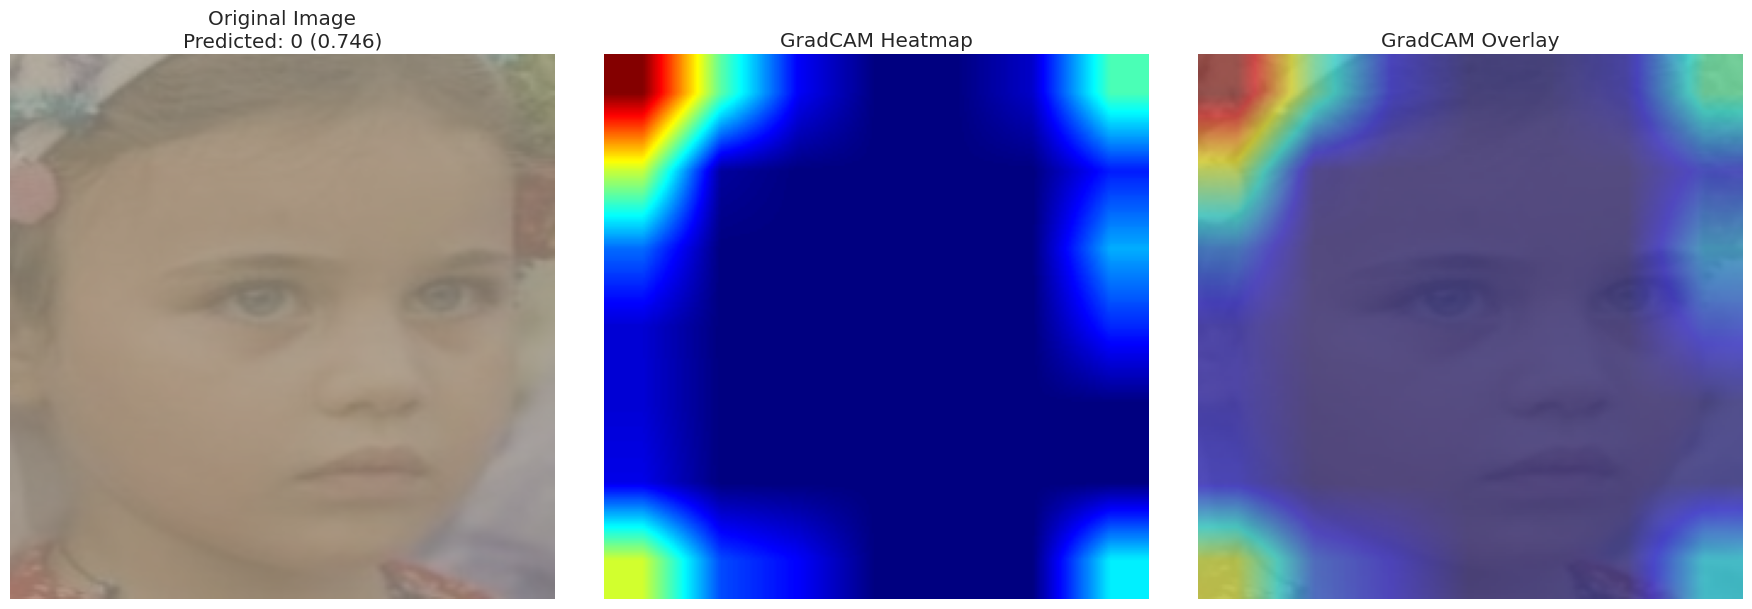

✅ GradCAM analysis completed successfully!


In [12]:
# Find sample images for analysis
print("\n🔍 Finding sample images for GradCAM analysis...")

sample_images = []
if os.path.exists(DATA_PATH):
    # Look for images in test directory
    test_dirs = [os.path.join(DATA_PATH, 'test'), os.path.join(DATA_PATH, 'valid'), DATA_PATH]

    for test_dir in test_dirs:
        if os.path.exists(test_dir):
            # Find all jpg files
            jpg_files = glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True)
            if jpg_files:
                sample_images = jpg_files[:5]  # Take first 5 images
                print(f"✅ Found {len(sample_images)} sample images in {test_dir}")
                break

if not sample_images:
    print("❌ No sample images found for analysis")
else:
    print("📸 Sample images:")
    for i, img_path in enumerate(sample_images):
        print(f"  {i+1}. {os.path.basename(img_path)}")

# Perform GradCAM analysis if model is loaded
if model is not None and target_layer is not None and sample_images:
    print("\n🎨 Performing GradCAM analysis on sample images...")

    # Analyze first image in detail
    first_image = sample_images[0]
    print(f"\n🔬 Detailed analysis of: {os.path.basename(first_image)}")

    result = analyze_single_image_gradcam(model, target_layer, first_image, DEVICE)

    if result:
        # Display results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Original image
        axes[0].imshow(result['original_image'])
        axes[0].set_title(f'Original Image\nPredicted: {result["predicted_class"]} ({result["confidence"]:.3f})')
        axes[0].axis('off')

        # GradCAM heatmap
        axes[1].imshow(result['heatmap'])
        axes[1].set_title('GradCAM Heatmap')
        axes[1].axis('off')

        # Overlay
        axes[2].imshow(result['overlay'])
        axes[2].set_title('GradCAM Overlay')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print("✅ GradCAM analysis completed successfully!")
    else:
        print("❌ GradCAM analysis failed")

elif model is None:
    print("❌ Cannot perform analysis - model not loaded")
elif not sample_images:
    print("❌ Cannot perform analysis - no sample images found")


📊 Performing batch GradCAM analysis...
🔍 Performing batch GradCAM analysis on 5 images...
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully


 40%|████      | 2/5 [00:00<00:00, 18.81it/s]

🔍 Analyzing GradCAM for: /kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.111.jpg
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully
✅ Analysis complete - Predicted: 0 (confidence: 0.746)
🔍 Analyzing GradCAM for: /kaggle/input/autism-image-data/AutismDataset/test/Autistic.110.jpg
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully
✅ Analysis complete - Predicted: 0 (confidence: 1.000)
🔍 Analyzing GradCAM for: /kaggle/input/autism-image-data/AutismDataset/test/Autistic.44.jpg
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully
✅ Analysis complete - Predicted: 0 (confidence: 1.000)
🔍 Analyzing GradCAM for: /kaggle/input/autism-image-data/AutismDataset/test/Autistic.134.jpg
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully


100%|██████████| 5/5 [00:00<00:00, 17.89it/s]


✅ Analysis complete - Predicted: 0 (confidence: 0.996)
🔍 Analyzing GradCAM for: /kaggle/input/autism-image-data/AutismDataset/test/Non_Autistic.136.jpg
🎨 Creating GradCAM for EfficientNet-B0...
✅ GradCAM created successfully
✅ Analysis complete - Predicted: 1 (confidence: 1.000)
✅ Batch analysis complete - 5 successful analyses

✅ Batch analysis completed on 5 images


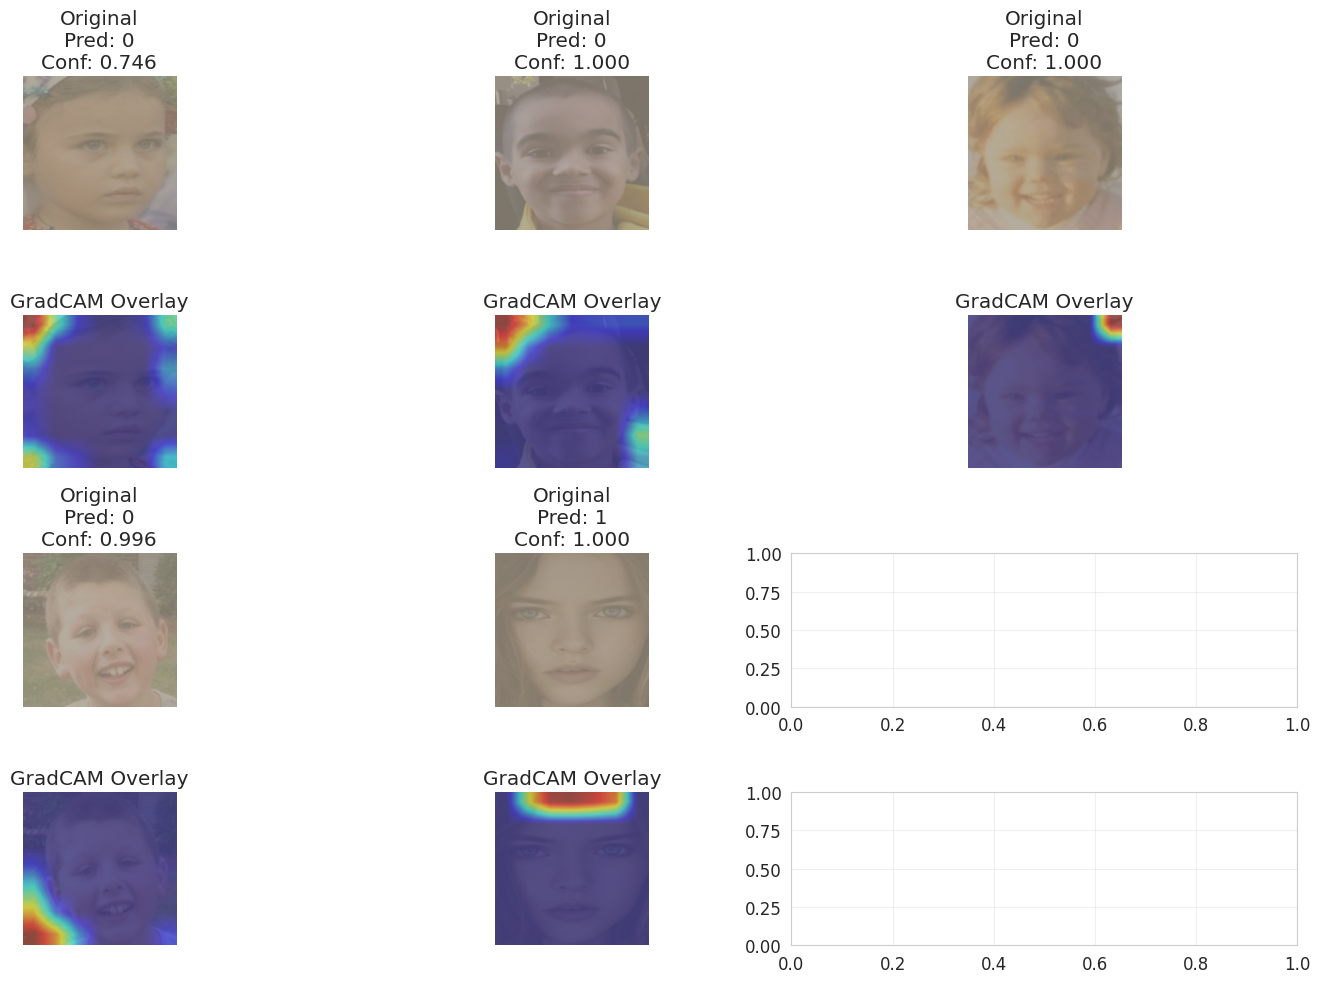

📈 Batch Analysis Summary:
   Average confidence: 0.948
   Prediction distribution: [4 1]


In [13]:
# Perform batch GradCAM analysis on multiple images
if model is not None and target_layer is not None and len(sample_images) > 1:
    print("\n📊 Performing batch GradCAM analysis...")

    batch_results = batch_gradcam_analysis(
        model=model,
        target_layer=target_layer,
        image_paths=sample_images,
        device=DEVICE,
        max_images=min(5, len(sample_images))
    )

    if batch_results:
        print(f"\n✅ Batch analysis completed on {len(batch_results)} images")

        # Plot results
        plot_gradcam_results(batch_results)

        # Summary statistics
        predictions = [r['predicted_class'] for r in batch_results]
        confidences = [r['confidence'] for r in batch_results]

        print("📈 Batch Analysis Summary:")
        print(f"   Average confidence: {np.mean(confidences):.3f}")
        print(f"   Prediction distribution: {np.bincount(predictions)}")

    else:
        print("❌ Batch analysis failed")
else:
    print("⏭️  Skipping batch analysis (insufficient data)")

In [14]:
# Load EfficientNet-B0 model and perform comprehensive analysis
print("🚀 Starting EfficientNet-B0 GradCAM Analysis")
print("=" * 60)

# Find EfficientNet-B0 model files
effnet_b0_model_path = None
for path in MODEL_PATH_OPTIONS:
    if os.path.exists(path):
        files = [f for f in os.listdir(path) if f.endswith('.pth')]
        effnet_b0_files = [f for f in files if 'effnet' in f.lower() and 'b0' in f.lower()]
        if effnet_b0_files:
            effnet_b0_model_path = os.path.join(path, effnet_b0_files[0])
            print(f"✅ Found EfficientNet-B0 model: {effnet_b0_model_path}")
            break

if effnet_b0_model_path is None:
    print("❌ No EfficientNet-B0 model found. Please ensure model files are available.")
    print("Expected filename pattern: *effnet*b0*.pth")
    model = None
    target_layer = None
else:
    # Perform comprehensive analysis
    analysis_result = comprehensive_efficientnet_b0_analysis(effnet_b0_model_path, DEVICE)

    if analysis_result["status"] == "success":
        model = analysis_result["model"]
        target_layer = analysis_result["target_layer"]

        print("\n🎯 Model loaded successfully! Ready for GradCAM analysis.")
        print(f"📊 Model: EfficientNet-B0")
        print(f"🎨 Target layer: {type(target_layer).__name__}")
        print(f"📍 Device: {DEVICE}")

        # Test model with dummy input
        dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
        with torch.no_grad():
            output = model(dummy_input)
            print(f"✅ Model forward pass test: {output.shape}")

    else:
        print(f"❌ Analysis failed: {analysis_result['reason']}")
        model = None
        target_layer = None

🚀 Starting EfficientNet-B0 GradCAM Analysis
✅ Found EfficientNet-B0 model: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_effnet-b0.pth
🚀 COMPREHENSIVE EFFICIENTNET-B0 MODEL ANALYSIS
🔧 Loading EfficientNet-B0 model: /kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_effnet-b0.pth
 Creating base torchvision EfficientNet-B0 model...
 Loading checkpoint...
✓ Checkpoint loaded successfully (strategy 1)
✓ Using checkpoint as state dict
📋 Checkpoint keys: ['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.0.block.0.0.weight', 'features.1.0.block.0.1.weight', 'features.1.0.block.0.1.bias', 'features.1.0.block.0.1.running_mean', 'features.1.0.block.0.1.running_var', 'features.1.0.block.0.1.num_batches_tracked', 'features.1.0.block.1.fc1.weight', 'features.1.0.block.1.fc1.bias', 'features.1


🔍 Finding sample images for GradCAM analysis...
✅ Found 5 sample images in /kaggle/input/autism-image-data/AutismDataset/test
📸 Sample images:
  1. Non_Autistic.111.jpg
  2. Autistic.110.jpg
  3. Autistic.44.jpg
  4. Autistic.134.jpg
  5. Non_Autistic.136.jpg

🔍 Generating EfficientNet-B0 GradCAM Analysis Insights
📊 Analysis Statistics:
   Total images analyzed: 5
   Classes predicted: {0: 4, 1: 1}
   Mean confidence: 0.948
   Std confidence: 0.101
   Min/Max confidence: 0.746/1.000

🎯 Confidence Distribution:
   High confidence (>0.8): 4 images
   Medium confidence (0.6-0.8): 1 images
   Low confidence (≤0.6): 0 images

🖼️  Saving individual GradCAM images...
   ✓ Saved images for Non_Autistic.111
   ✓ Saved images for Autistic.110
   ✓ Saved images for Autistic.44
   ✓ Saved images for Autistic.134
   ✓ Saved images for Non_Autistic.136
✅ Saved 5 sets of GradCAM images to: /kaggle/working/efficientnet_b0_gradcam_images
📄 Summary saved to: /kaggle/working/efficientnet_b0_gradcam_summ

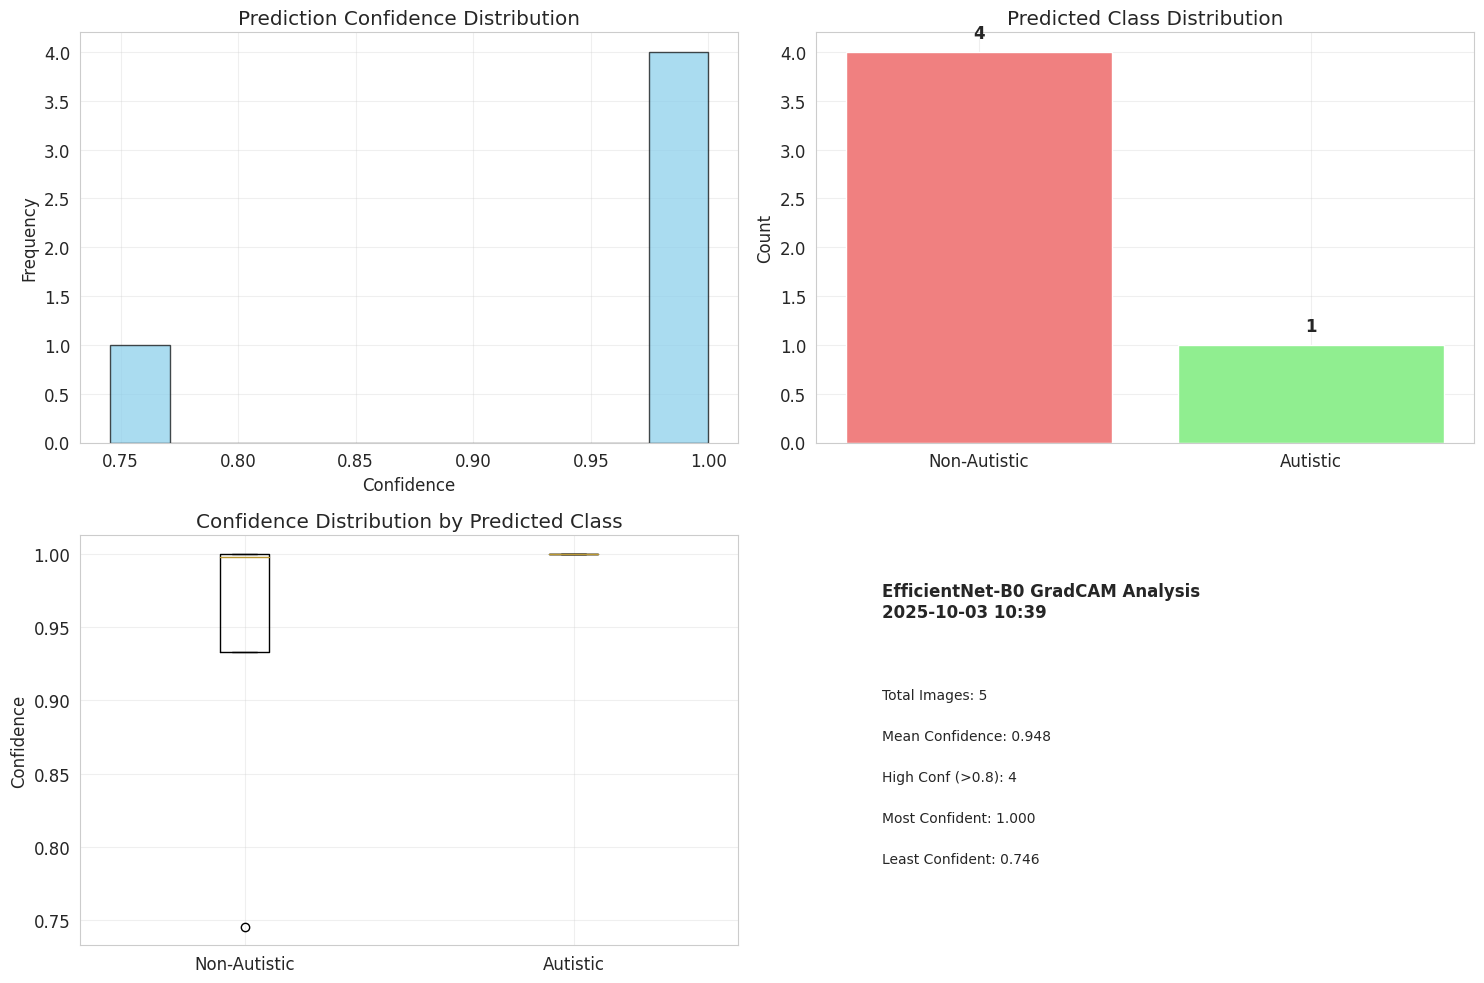

In [15]:
# Find sample images for analysis
print("\n🔍 Finding sample images for GradCAM analysis...")

sample_images = []
if os.path.exists(DATA_PATH):
    # Look for images in test directory
    test_dirs = [os.path.join(DATA_PATH, 'test'), os.path.join(DATA_PATH, 'valid'), DATA_PATH]

    for test_dir in test_dirs:
        if os.path.exists(test_dir):
            # Find all jpg files
            jpg_files = glob.glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True)
            if jpg_files:
                sample_images = jpg_files[:5]  # Take first 5 images
                print(f"✅ Found {len(sample_images)} sample images in {test_dir}")
                break

if not sample_images:
    print("❌ No sample images found for analysis")
else:
    print("📸 Sample images:")
    for i, img_path in enumerate(sample_images):
        print(f"  {i+1}. {os.path.basename(img_path)}")

# Perform GradCAM analysis if model is loaded
if model is not None and target_layer is not None and sample_images:
    print("\n🔍 Generating EfficientNet-B0 GradCAM Analysis Insights")
    print("=" * 60)

    # Calculate statistics
    predictions = np.array([r['predicted_class'] for r in batch_results])
    confidences = np.array([r['confidence'] for r in batch_results])

    # Class distribution
    unique_preds, counts = np.unique(predictions, return_counts=True)
    class_distribution = dict(zip(unique_preds, counts))

    print("📊 Analysis Statistics:")
    print(f"   Total images analyzed: {len(batch_results)}")
    print(f"   Classes predicted: {class_distribution}")
    print(f"   Mean confidence: {np.mean(confidences):.3f}")
    print(f"   Std confidence: {np.std(confidences):.3f}")
    print(f"   Min/Max confidence: {np.min(confidences):.3f}/{np.max(confidences):.3f}")
    # Confidence analysis
    high_conf = np.sum(confidences > 0.8)
    med_conf = np.sum((confidences > 0.6) & (confidences <= 0.8))
    low_conf = np.sum(confidences <= 0.6)

    print("\n🎯 Confidence Distribution:")
    print(f"   High confidence (>0.8): {high_conf} images")
    print(f"   Medium confidence (0.6-0.8): {med_conf} images")
    print(f"   Low confidence (≤0.6): {low_conf} images")

    # Save individual GradCAM images
    print(f"\n🖼️  Saving individual GradCAM images...")

    # Create directory for individual images
    images_dir = os.path.join(OUTPUT_PATH, 'efficientnet_b0_gradcam_images')
    os.makedirs(images_dir, exist_ok=True)

    saved_images = 0
    for i, result in enumerate(batch_results):
        try:
            # Get base filename without extension
            base_name = os.path.splitext(os.path.basename(result['image_path']))[0]

            # Save original image
            plt.figure(figsize=(6, 6))
            plt.imshow(result['original_image'])
            plt.title(f'Original - {base_name}\nPred: {result["predicted_class"]} (Conf: {result["confidence"]:.3f})')
            plt.axis('off')
            original_path = os.path.join(images_dir, f'{base_name}_original.png')
            plt.savefig(original_path, dpi=300, bbox_inches='tight')
            plt.close()

            # Save GradCAM heatmap
            plt.figure(figsize=(6, 6))
            plt.imshow(result['heatmap'])
            plt.title(f'GradCAM Heatmap - {base_name}')
            plt.axis('off')
            heatmap_path = os.path.join(images_dir, f'{base_name}_heatmap.png')
            plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
            plt.close()

            # Save GradCAM overlay
            plt.figure(figsize=(6, 6))
            plt.imshow(result['overlay'])
            plt.title(f'GradCAM Overlay - {base_name}\nPred: {result["predicted_class"]} (Conf: {result["confidence"]:.3f})')
            plt.axis('off')
            overlay_path = os.path.join(images_dir, f'{base_name}_overlay.png')
            plt.savefig(overlay_path, dpi=300, bbox_inches='tight')
            plt.close()

            saved_images += 1
            print(f"   ✓ Saved images for {base_name}")

        except Exception as e:
            print(f"   ⚠️  Failed to save images for {os.path.basename(result['image_path'])}: {e}")

    print(f"✅ Saved {saved_images} sets of GradCAM images to: {images_dir}")

    # Save results summary as text file instead of JSON
    results_file = os.path.join(OUTPUT_PATH, 'efficientnet_b0_gradcam_summary.txt')
    with open(results_file, 'w') as f:
        f.write("EfficientNet-B0 GradCAM Analysis Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Analysis Timestamp: {pd.Timestamp.now().isoformat()}\n")
        f.write(f"Total Images Analyzed: {len(batch_results)}\n")
        f.write(f"Classes Predicted: {class_distribution}\n")
        f.write(".3f")
        f.write(".3f")
        f.write(".3f")
        f.write(f"High Confidence (>0.8): {high_conf} images\n")
        f.write(f"Medium Confidence (0.6-0.8): {med_conf} images\n")
        f.write(f"Low Confidence (≤0.6): {low_conf} images\n\n")
        f.write("Individual Results:\n")
        f.write("-" * 30 + "\n")
        for r in batch_results:
            f.write(f"Image: {os.path.basename(r['image_path'])}\n")
            f.write(f"  Predicted Class: {r['predicted_class']}\n")
            f.write(f"  Confidence: {r['confidence']:.3f}\n")
            f.write(f"  Images saved in: {images_dir}\n\n")

    print(f"📄 Summary saved to: {results_file}")

    # Create summary visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Confidence histogram
    ax1.hist(confidences, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Prediction Confidence Distribution')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)

    # Class distribution
    class_names = ['Non-Autistic', 'Autistic']  # Assuming 0=Non-Autistic, 1=Autistic
    class_counts = [class_distribution.get(0, 0), class_distribution.get(1, 0)]
    bars = ax2.bar(class_names, class_counts, color=['lightcoral', 'lightgreen'])
    ax2.set_title('Predicted Class Distribution')
    ax2.set_ylabel('Count')
    for bar, count in zip(bars, class_counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom', fontweight='bold')

    # Confidence by class
    class_0_conf = [r['confidence'] for r in batch_results if r['predicted_class'] == 0]
    class_1_conf = [r['confidence'] for r in batch_results if r['predicted_class'] == 1]

    ax3.boxplot([class_0_conf, class_1_conf], labels=class_names)
    ax3.set_title('Confidence Distribution by Predicted Class')
    ax3.set_ylabel('Confidence')
    ax3.grid(True, alpha=0.3)

    # Summary text
    ax4.text(0.1, 0.8, f'EfficientNet-B0 GradCAM Analysis\n{pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")}', fontsize=12, fontweight='bold')
    ax4.text(0.1, 0.6, f'Total Images: {len(batch_results)}', fontsize=10)
    ax4.text(0.1, 0.5, f'Mean Confidence: {np.mean(confidences):.3f}', fontsize=10)
    ax4.text(0.1, 0.4, f'High Conf (>0.8): {high_conf}', fontsize=10)
    ax4.text(0.1, 0.3, f'Most Confident: {np.max(confidences):.3f}', fontsize=10)
    ax4.text(0.1, 0.2, f'Least Confident: {np.min(confidences):.3f}', fontsize=10)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')

    plt.tight_layout()

    # Save summary plot
    summary_plot_file = os.path.join(OUTPUT_PATH, 'efficientnet_b0_gradcam_summary.png')
    plt.savefig(summary_plot_file, dpi=300, bbox_inches='tight')
    print(f"📊 Summary plot saved to: {summary_plot_file}")

    plt.show()

else:
    print("⏭️  Skipping insights generation (no batch results available)")